In [3]:
%config IPCompleter.greedy=True

In [123]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from matplotlib import image
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

# 1

Разбейте множество объектов из набора данных pluton.csv на 3 кластера с помощью kmeans. Сравните качество разбиения в зависимости от максимального числа итераций алгоритма и использования стандартизации.

## 1.0

Загрузка данных

In [102]:
def load_data(filename: str, tab_separated=False, as_df=False):
    prefix = os.readlink('requisites')
    path = os.path.join(prefix, filename)
    data = pd.read_csv(path, sep=('\t' if tab_separated else ','))
    if as_df:
        return data
    else:
        return data.to_numpy()

In [16]:
pluton_data = load_data('pluton.csv')
pluton_data_standard = (pluton_data + np.where(pluton_data.min()<0, abs(pluton_data.min()), 0)) / pluton_data.max(axis=0)

## 1.1

Создание кластеризатора и кластеризация

In [26]:
scores = {}
x_axis = list(range(5, 506, 10))

for data_type, dataset in zip(('non-normalized', 'normalized'), (pluton_data, pluton_data_standard)):
    scores[data_type] = []
    for max_iter in x_axis:
        clusterizer = sklearn.cluster.KMeans(n_clusters=3, max_iter=max_iter)
        scores[data_type].append(clusterizer.fit(pluton_data).score(dataset))

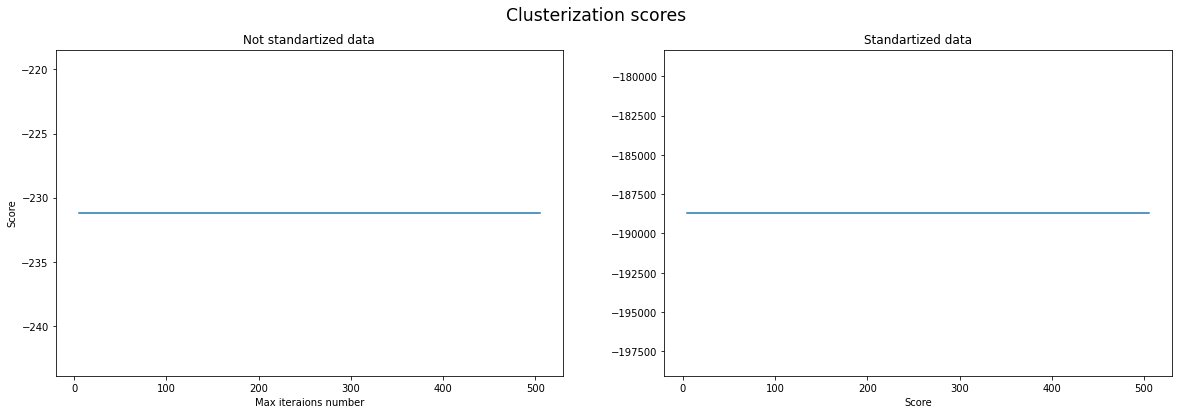

In [28]:
fig = plt.figure(figsize=(20, 6))
fig.suptitle('Clusterization scores', fontsize='xx-large')
base_ax = fig.add_subplot(121)
norm_ax = fig.add_subplot(122)
base_ax.set_title('Not standartized data')
norm_ax.set_title('Standartized data')
base_ax.set_xlabel('Max iteraions number')
norm_ax.set_xlabel('Max iteraions number')
base_ax.set_ylabel('Score')
norm_ax.set_xlabel('Score')
base_ax.plot(x_axis, scores['non-normalized'])
norm_ax.plot(x_axis, scores['normalized'])
plt.show()

In [40]:
sklearn.cluster.KMeans(n_clusters=3, max_iter=max_iter).fit(pluton_data_standard).predict([[0.001, 0.001, 0.001, 0.0001]])

array([1], dtype=int32)

# 2

Разбейте на кластеры множество объектов из наборов данных clustering_1.csv, clustering_2.csv и clustering_3.csv с помощью k-means, DBSCAN и иерархической кластеризации. Определите оптимальное количество кластеров (где это применимо). Какой из методов сработал лучше и почему? 

## 2.0

Загрузка и демонстрация данных

In [50]:
filenames = ('clustering_1.csv', 'clustering_2.csv', 'clustering_3.csv')

clustering_1, clustering_2, clustering_3 = (load_data(i, tab_separated=True) for i in filenames)

datasets = (clustering_1, clustering_2, clustering_3)

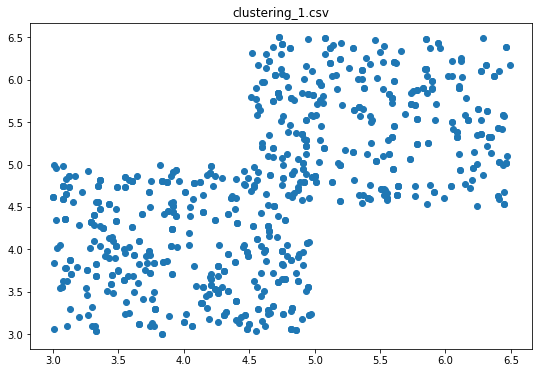

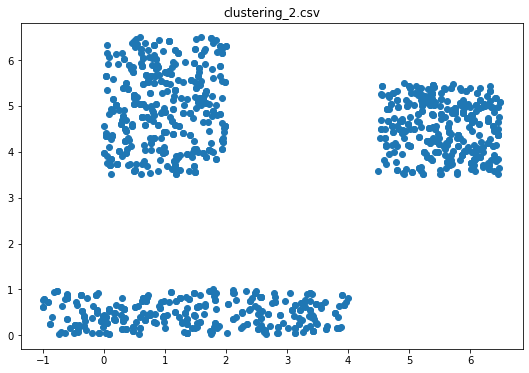

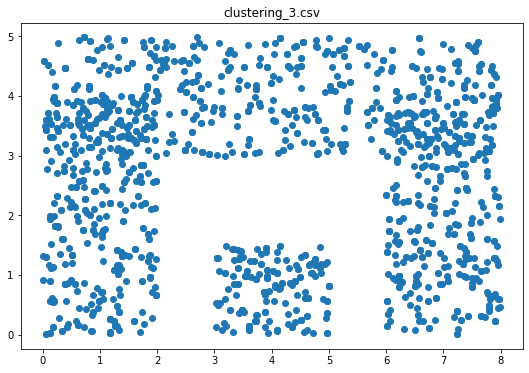

In [51]:
for name, data in zip(filenames, datasets):
    figure = plt.figure(figsize=(9, 6))
    ax = plt.gca()
    ax.scatter(data[:,0], data[:,1])
    ax.set_title(name)
    plt.show()

## 2.1

Создание кластеризаторов и их обучение

In [58]:
def transform_to_color(label):
    colors = label.astype('<U21')
    colors = np.where(colors == '0', 'blue', colors)
    colors = np.where(colors == '1', 'red', colors)
    colors = np.where(colors == '2', 'green', colors)
    colors = np.where(colors == '3', 'yellow', 'black')
    return colors

In [59]:
clfs = {}

cluster_types = ('K-Means', 'DBSCAN', 'Hierarchical')
clusterizers = (KMeans, DBSCAN, AgglomerativeClustering)
cluster_counts = {k: v for k, v in zip(filenames, (2, 3, 4))}

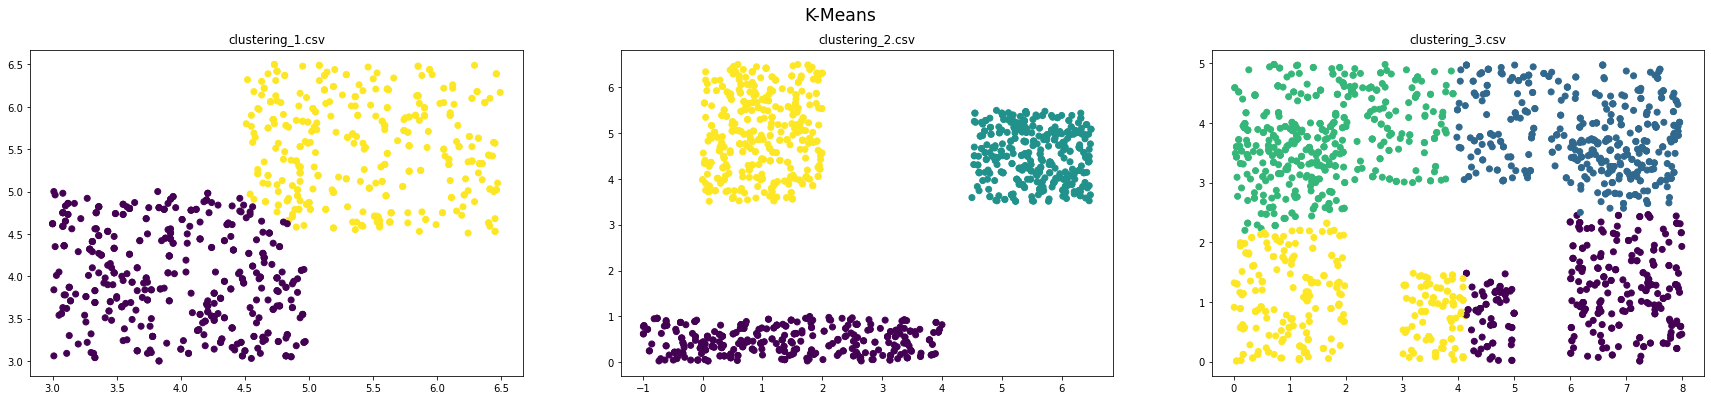

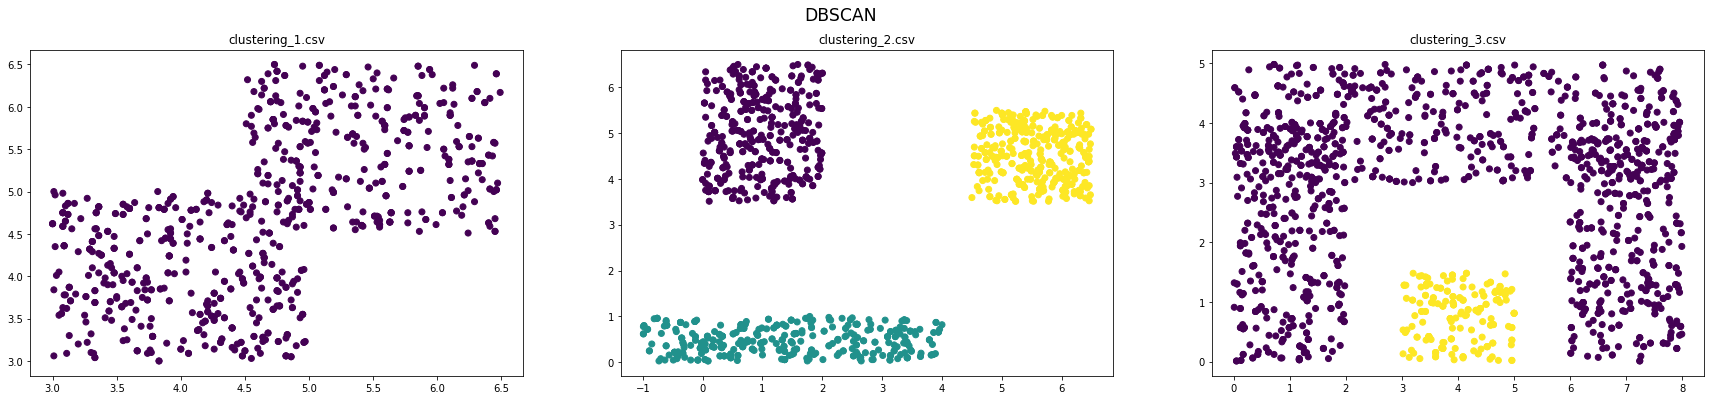

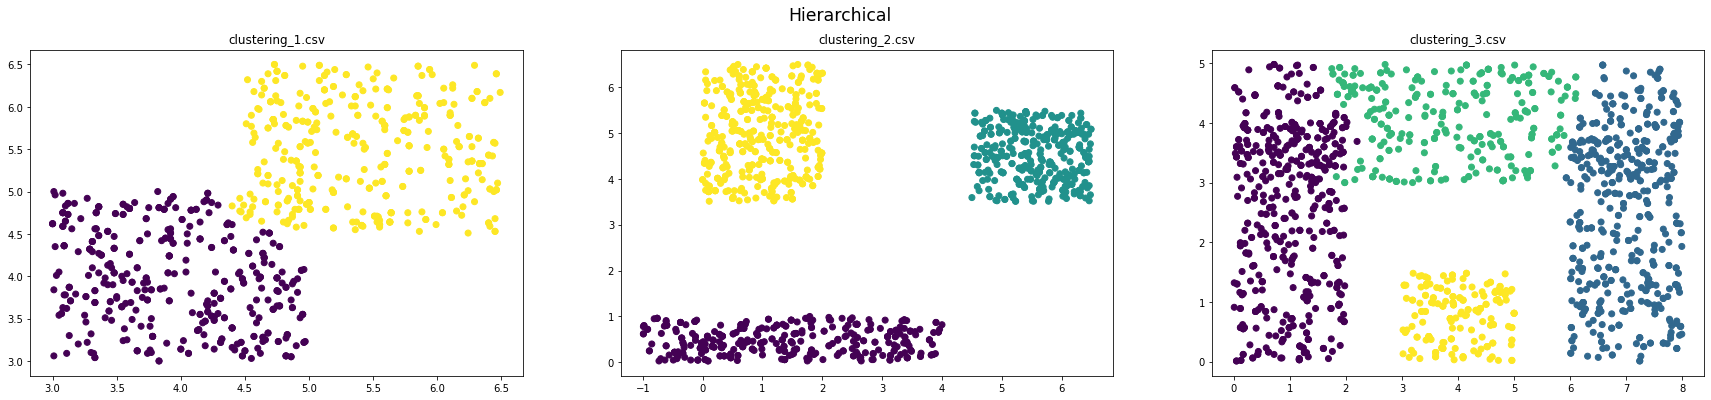

In [74]:
for cluster_type, clusterizer in zip(cluster_types, clusterizers):
    figure = plt.figure(figsize=(30, 6))
    for subplt_num, (name, data) in enumerate(zip(filenames, datasets)):
        if cluster_type != 'DBSCAN':
            colors = clusterizer(n_clusters=cluster_counts[name]).fit_predict(data)
        else:
            colors = clusterizer().fit(data).fit_predict(data)
        figure.suptitle(cluster_type, fontsize='xx-large')
        ax = figure.add_subplot(1, 3, subplt_num+1)
        ax.set_title(name)
        ax.scatter(data[:,0], data[:,1], c=colors)
    plt.show()

# 3

Осуществите сжатие цветовой палитры изображения (любого, на ваш выбор). Для этого выделите n кластеров из цветов всех пикселей изображения и зафиксируйте центра этих кластеров. Создайте изображение с цветами из сокращенной палитры (цвета пикселей только из центров выделенных кластеров). Покажите исходное и сжатое изображения.

In [91]:
def load_image(filename: str) -> np.array:
    prefix = os.readlink('requisites')
    path = os.path.join(prefix, filename)
    im = image.imread(path)[:, :, :3]
    shape = im.shape
    plt.imshow(im)
    plt.show()
    return im.reshape(shape[0]*shape[1], -1), shape

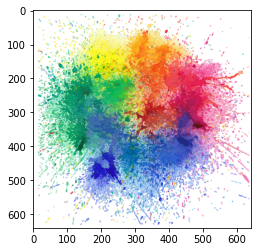

In [139]:
pic, shape = load_image('image_my.png')
clusterizer = KMeans().fit(pic)
centers = {class_num: class_val for class_num, class_val in enumerate(clusterizer.cluster_centers_)}

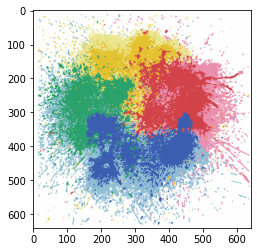

In [140]:
predictions = clusterizer.predict(pic)
for i in range(predictions.shape[0]):
    color = centers[predictions[i]]
    pic[i] = color
pic = pic.reshape(shape[0], shape[1], -1)
plt.imshow(pic)
plt.show()

# 4

Постройте дендрограмму для набора данных votes.csv (число голосов, поданных за республиканцев на выборах с 1856 по 1976 год). Строки представляют 50 штатов, а столбцы - годы выборов (31). Проинтерпретируйте полученный результат.

In [118]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(100, 100))
    ax = plt.gca()
    dendrogram(linkage_matrix, ax=ax, **kwargs)

In [119]:
votes = load_data('votes.csv', as_df=True)
votes = votes.fillna(0)

47.0


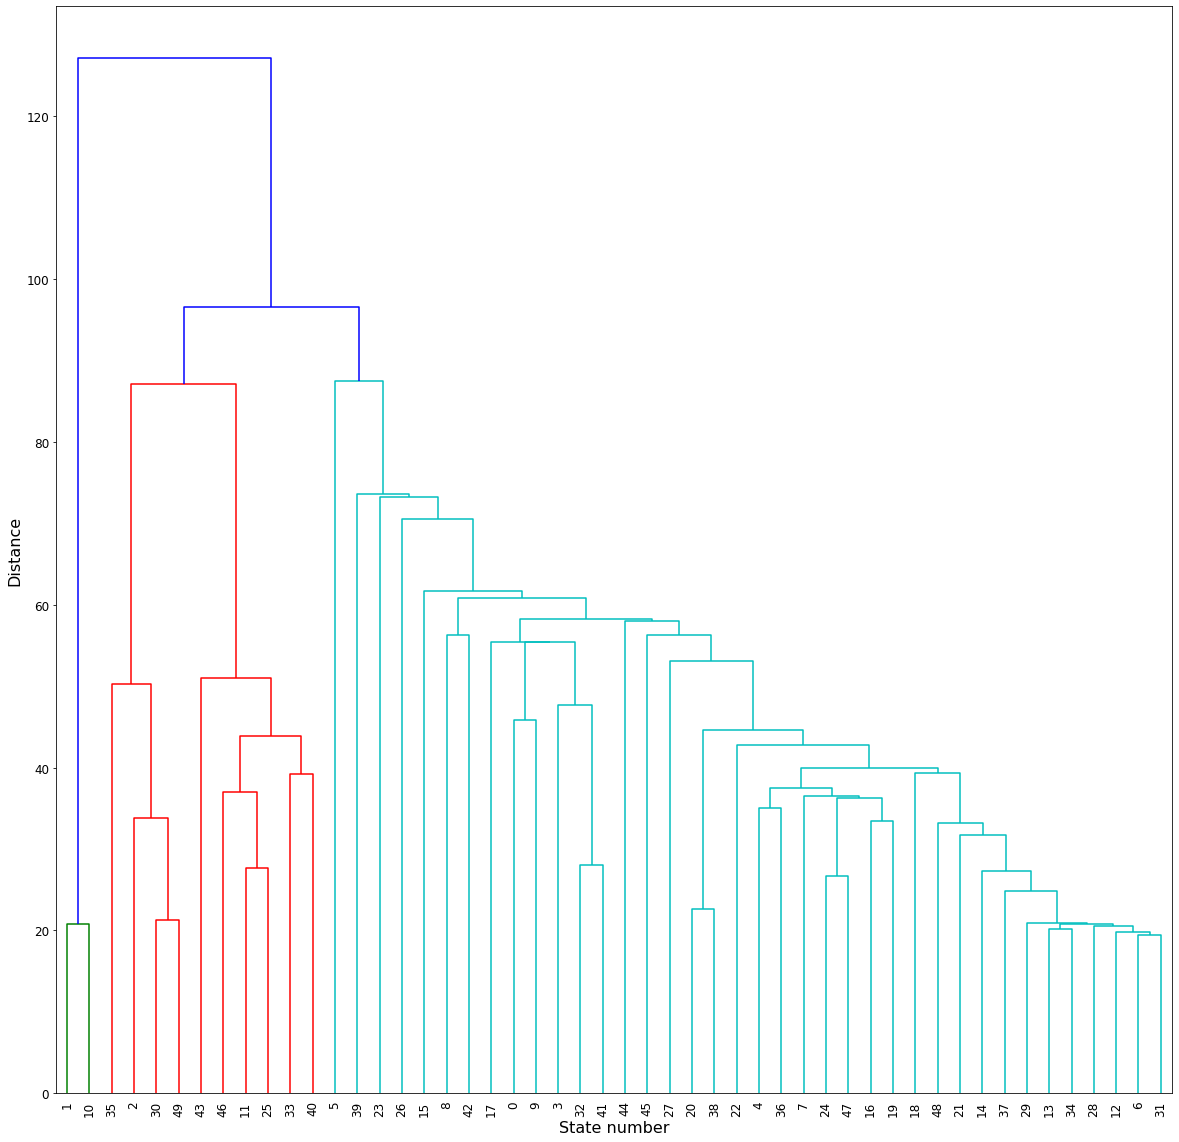

In [134]:
Z = hierarchy.linkage(votes, 'single')
print(Z[10, 1])
plt.figure(figsize=(20, 20))
ax = plt.gca()
ax.set_ylabel('Distance', fontsize=16)
ax.set_xlabel('State number', fontsize=16)
dn = hierarchy.dendrogram(Z, ax=ax)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
plt.show()